## Kernel Logistic Regression and SVMs

In this notebook, we will look at the behavior of logistic regression as compared to SVMs, in both the standard (i.e. linear kernel) and kernelized cases. We will work using toy data generated from various distributions.

We will first generate some data from two overlapping Gaussians, and see how they are separated using both techniques.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual, IntSlider
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from tqdm import *

In [2]:
def gen_gaussian_points(n, mean, sigma):
    return np.random.normal(mean, sigma, [n, 2])
    

N = 100

class_a = gen_gaussian_points(N, [-1, -1], [1, 1])
class_b = gen_gaussian_points(N, [1, 1], [1, 1])

X = np.vstack([class_a, class_b])
y = np.vstack([[-1]] * N + [[1]] * N).reshape((-1,))

In [3]:
def logistic_regression(X, y):
    model = LogisticRegression()
    model.fit(X, y)
    
    return model.coef_

Now, we will generate some points from two different distributions and verify that logistic regression separates them well.

[[1.83904148]
 [1.76054044]]


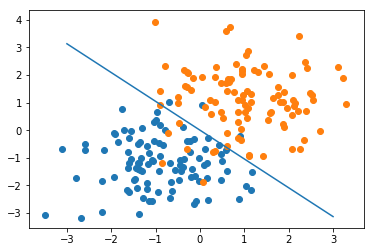

In [4]:
w = logistic_regression(X, y).T
print(w)
plt.scatter(*class_a.T)
plt.scatter(*class_b.T)
plt.plot(np.linspace(-3, 3, 50), -np.linspace(-3, 3, 50) * w[0] / w[1])
plt.show()

Of course, this approach only works when our points are roughly linearly separable. Otherwise, one approach is to consider some kernel function rather than acting on the features directly. One such kernel function, that we have seen before when looking at kernel least squares, is the polynomial kernel. We supply an implementation below.

In [5]:
def polynomial_kernel(degree=2):
    def kernel(X, Y=None):
        # this line lets us compute the inner product between
        # two different datasets without having to stack them
        # into a single matrix
        Y = X if Y is None else Y

        # this is the actual computation
        return (X @ Y.T + 1) ** degree
    return kernel

### Part 1
Now, complete the implementation of the kernelized gradient descent step below, for logistic regression.

In [6]:
from scipy.special import expit

def s(x):
    return expit(x)

def gradient_step(a, gamma, K, y):
    """
    a is the vector of dual weights at time t
    gamma is the step size
    K is the kernel matrix Phi Phi^T for our dataset
    y is a column of labels
    """
    ### start gradient_step ###
    return a + gamma * (y - s(K @ a))
    ### end gradient_step ###

def kernel_logistic_regression(X, y, kernel, *, gamma=0.001, iterations=100, a_init=None):
    n, d = X.shape
    K = kernel(X)
    a = np.ones(n) / 100 if a_init is None else a_init # some arbitary initial values
    for _ in range(iterations):
        a = gradient_step(a, gamma, K, y)
        
    return a

def kernel_logistic_predict(a, X, X_test, kernel):
    K_test = kernel(X_test, X)
    return s(K_test @ a)

def visualize_decision_boundary(classifier):
    XX, YY = np.meshgrid(np.linspace(-4, 4, 100), np.linspace(-4, 4, 100))
    X0 = np.stack([np.ravel(XX), np.ravel(YY)]).T
    y0 = classifier(X0)
    ZZ = y0.reshape(100, 100)
    plt.contourf(XX, YY, ZZ, cmap="coolwarm", levels=np.linspace(0,1,3))
    plt.xlim(-4, 4)
    plt.ylim(-4, 4)

Let's see how well this works on some data that is not linearly separable. We will construct a dataset with the classes separated by their radial distance from the origin:

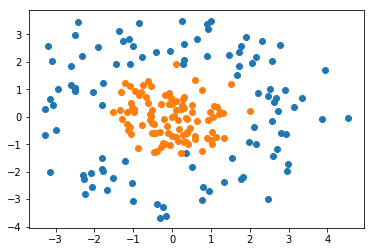

In [7]:
def gen_radial(n, mean, sigma):
    dists = np.random.normal(mean, sigma, n).reshape([n, 1])
    angles = np.random.uniform(0, 2 * np.pi, n)
    return dists * np.array([np.cos(angles), np.sin(angles)]).T
    

N = 100

class_a = gen_radial(N, 3, 0.5)
class_b = gen_radial(N, 1, 0.5)

X = np.vstack([class_a, class_b])
y = np.vstack([[0]] * N + [[1]] * N).reshape((-1,))
plt.scatter(*class_a.T)
plt.scatter(*class_b.T)

Now, let's try fitting a logistic classifier to this data, using a degree 2 polynomial kernel. 

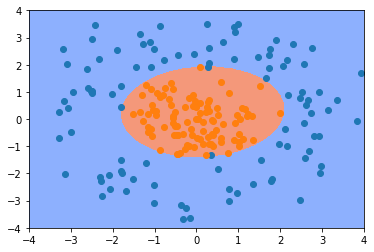

In [8]:
kernel = polynomial_kernel(degree=2)
a = kernel_logistic_regression(X, y, kernel, iterations=300000, gamma=1e-2)
classifier = lambda X_test: kernel_logistic_predict(a, X, X_test, kernel)
visualize_decision_boundary(classifier)
plt.scatter(*class_a.T)
plt.scatter(*class_b.T)

### Part 2

Try changing to a degree 1 kernel. Does it still successfully classify the training data? What if you make the degree of the kernel very large (say, 10)? How does this affect the accuracy and running time of the classifier? Also try varying the parameters of the distributions. Comment on your results.

### start observations-1 ###

### end observations-1 ###

This should be mostly expected. We saw last week that logistic regression produces a maximum-margin classifier in the case of separable data when trained using gradient descent, and that is indeed what we are observing. 

Last week, part of our argument essentially stated that it is only those points on the margin between the two classes that affect the logistic regression boundary. We can investigate whether that is true numerically, by looking at the magnitude of the dual weights for each of our points. We plot these magnitudes below:

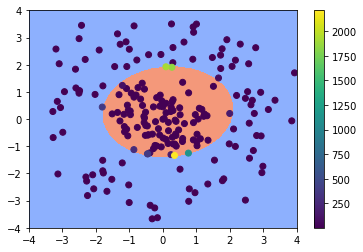

In [9]:
def plot_dual_weights(X, a):
    a = np.abs(a)
    idx = a.argsort()
    X = X[idx]
    a = a[idx]
    plt.scatter(*X.T, c=a)
    plt.colorbar()

visualize_decision_boundary(classifier)
plot_dual_weights(X, a)

Does the above plot match our expectations? (i.e. are the most heavily weighted points those at the margin of the classifier?)

### start observations-2 ###

### end observations-2 ###

## Part 3
Now, we will look at the case when our data points are not separable. We will generate points from a similar distribution to before, just with a larger standard deviation.

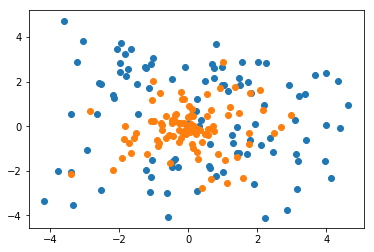

In [10]:
class_a = gen_radial(N, 3, 1)
class_b = gen_radial(N, 1, 1)

X = np.vstack([class_a, class_b])
y = np.vstack([[0]] * N + [[1]] * N).reshape((-1,))
plt.scatter(*class_a.T)
plt.scatter(*class_b.T)

Classifying using kernel logistic regression, we obtain the following decision boundary.

(-4, 4)

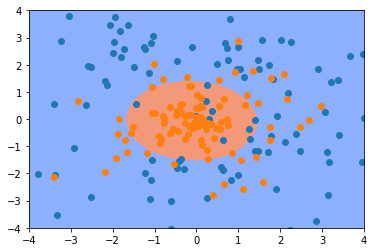

In [11]:
kernel = polynomial_kernel(degree=2)
a = kernel_logistic_regression(X, y, kernel, iterations=300000, gamma=1e-2)
classifier = lambda X_test: kernel_logistic_predict(a, X, X_test, kernel)
visualize_decision_boundary(classifier)
plt.scatter(*class_a.T)
plt.scatter(*class_b.T)
plt.xlim(-4,4)
plt.ylim(-4,4)

You should see that while the classifier correctly splits most of our training points by class, it incorrectly classifies some points. We can now look at the dual weights of each of our training points, just like before.

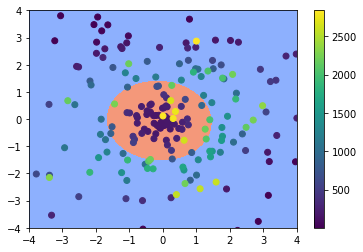

In [12]:
def plot_dual_weights(X, a):
    a = np.abs(a)
    idx = a.argsort()
    X = X[idx]
    a = a[idx]
    plt.scatter(*X.T, c=a)
    plt.colorbar()

visualize_decision_boundary(classifier)
plot_dual_weights(X, a)

Notice that the points on the margin have the highest weights, as before. But there are also some points _not_ on the margin with large dual weights. What distinguishes these points? Why did logistic regression assign them a high weight? 

### start observations-3 ###
These are the points that are misclassified by logistic regression, so they are applying a strong "pull" to move the decision boundary closer so they are correctly classified. Hence, they have a high weight in the final solution.
### end observations-3

## Part 4
Next, we will look at an alternative method of classifying points, that explicitly seeks to maximize the margin between the decision boundary and the test points: the SVM. We classify our earlier distribution using an SVM below, with a linear kernel (i.e. working using just the raw features):

[]

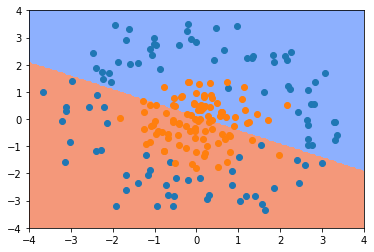

In [13]:
from sklearn import svm

class_a = gen_radial(N, 3, 0.5)
class_b = gen_radial(N, 1, 0.5)

X = np.vstack([class_a, class_b])
y = np.vstack([[0]] * N + [[1]] * N).reshape((-1,))

model = svm.LinearSVC() # SVC = support vector classifier, which we just call an SVM
model.fit(X, y)
visualize_decision_boundary(lambda X_test: model.predict(X_test))
plt.scatter(*class_a.T)
plt.scatter(*class_b.T)
plt.plot()

Comment on the accuracy of the linear SVM as compared to logistic regrsesion with polynomial kernels of various degrees. Did the linear SVM do any better? Should we have expected it to?

### start observations-4 ###

### end observations-4 ###

SVMs are very similar to logistic regression, in that they both try to construct a linear decision boundary to classify our data, focusing on the points near the boundary and disregarding those further away.

Logistic regression essentially reduces the "importance" of data points the further they are from the decision boundary. In contrast, SVMs can be thought of as *immediately* ignoring all points that are correctly classified, unless they are right on the margin. This is a similar effect to what we have just seen with logistic regression - SVMs exhibit this property exactly even when the data is not linearly separable.

Considering SVMs from the perspective of the dual, we see as a consequence that the only nonzero coefficients in the dual solution correspond to either points with nonzero slack, or points that lie on the margin. Since in most real-world cases, we expect the majority of training points to be correctly classified, this means that the dual weights of an SVM are _sparse_, with only a few nonzero weights.

Imagine that we have $n$ training points, $a$ of which are on the SVM margin, and a further $b$ of which are inside the margin and so have nonzero slack. How many weights in the _primal_ weight vector $\vec{w}$ computed after training an SVM can be nonzero? What about in the _dual_ weight vector $\vec{a}$? (Recall that $\vec{w} = \mathbf{X}\vec{a}$). 

Then answer the same questions again, but for weights trained using logistic regression, not using an SVM. What does this tell you about the computational complexity of classification using SVMs versus logistic regression? (i.e. given a model, consider the time complexity to classify a single test point in both cases)

### start calculation ###

### end calculation ###

## Part 5

Taking inspiration from the sparse solutions from the SVM, we can try to obtain similarly sparse solutions from logistic regression directly, by simply rounding the smallest dual weights to zero. Notice how it only makes sense to do this with the dual solution, since discarding the smallest dual weights can be interpreted as discarding the contributions of points very far into the correct side, which we know don't have a significant impact on logistic regression anyway. **Explain why discarding the smallest weights in the primal weight vector, rather than the dual, obtained by logistic regression could cause issues**.

### start explanation ###

### end explanation ###

The below cell plots the number of components rounded to zero against the training accuracy, using the nonlinear classification problem we saw earlier and solving using logistic regression with a quadratic kernel. 

Note that we take a small number of gradient steps after rounding, since the effects of the discarded points (though small) may have shifted our classifier slightly in aggregate, so a couple of gradient steps will help to "re-align" our classifier while using only a subset of the original training points, and yielding a solution essentially identical to the original non-sparse one.

Run the cell and comment on your observations.

Text(0,0.5,'Training accuracy')

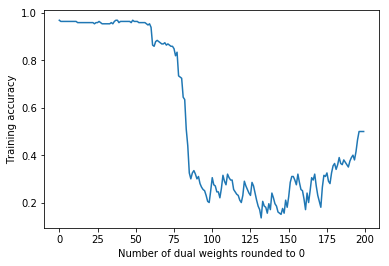

In [14]:
def accuracy(y_pred, y):
    binary_preds = y_pred > 0.5
    return np.sum(y == binary_preds) / n

# a small number of gradient steps taken after discarding the small dual weights, 
# far fewer than those taken in the initial training
NUM_REWEIGHT_ITERATIONS = 10

kernel = polynomial_kernel(degree=2)
a = kernel_logistic_regression(X, y, kernel, iterations=30000, gamma=1e-2)
n, d = X.shape

a_deleted = a.copy()
deleted_indices = []
updated_as = []
updated_Xs = []
accuracies = []
for num_zeroed_components in range(n):
    if np.nonzero(a_deleted)[0].size == 0:
        break
    [[i, *_]] = np.where(np.abs(a_deleted) == np.min(np.abs(a_deleted[np.nonzero(a_deleted)])))
    a_deleted[i] = 0
    deleted_indices.append(i)
    a_updated = kernel_logistic_regression(
        X[a_deleted != 0],
        y[a_deleted != 0],
        kernel,
        iterations=NUM_REWEIGHT_ITERATIONS,
        gamma=1e-2,
        a_init=a_deleted[a_deleted != 0],
    )
    updated_Xs.append(X[a_deleted != 0])
    updated_as.append(a_updated)
    classes = kernel_logistic_predict(a_updated, X[a_deleted != 0], X, kernel)
    accuracies.append(accuracy(classes, y))
    
plt.plot(accuracies)
plt.xlabel("Number of dual weights rounded to 0")
plt.ylabel("Training accuracy")

### start observations-5 ###

### end observations-5 ###

## Part 6
Another way to visualize this effect is to watch points get deleted from the model as we increase the desired level of sparsity. Run the below cell and drag the slider to the right. Which points have the least contribution to the logistic regression solution, and so get deleted first? When does the model start to break down?

In [15]:
def plot(i):
    remaining_indices = deleted_indices[i:]
    pts = X[remaining_indices]
    labels = y[remaining_indices]
    class_a = pts[labels == 0]
    class_b = pts[labels == 1]
        
    visualize_decision_boundary(lambda X_test: kernel_logistic_predict(updated_as[i], updated_Xs[i], X_test, kernel))  
    
    plt.scatter(*class_a.T)
    plt.scatter(*class_b.T)
    plt.xlim(-4, 4)
    plt.ylim(-4, 4)
    
    
interact(plot, i=IntSlider(min=0, max=n, continuous_update=False))

interactive(children=(IntSlider(value=0, continuous_update=False, description='i', max=200), Output()), _dom_c…

<function __main__.plot(i)>

Comment on the behavior you observe above. Is selecting a sparse solution from logistic regression a feasible alternative to the SVM? Why or why not?

### start observations-6 ###

### end observations-6 ###

## Part 7 (no work required)
In the final part of this notebook, we will look at an application of Kernel SVM to classify the CIFAR-10 dataset, an image classification dataset. We first import necessary Python packages and define relevant functions.

This is intended just as a demo of kernel SVM on real-world data, that will be expanded on next week. For now, just look at the results!

In [16]:
from tqdm import *

def multiscale(X_train):
    X_train0 = np.reshape(X_train, (X_train.shape[0], -1))
    X_train2 = np.reshape(X_train[:,::2,::2,:], (X_train.shape[0], -1))
    return np.hstack((X_train0, X_train2))
def normalize(X):
    return (X - np.mean(X, axis=1, keepdims=True) )/np.std(X, axis=1, keepdims=True)
def svm_alg(c, g, xTrain, yTrain, xVal, yVal, *, kernel):
    svc_rbf = svm.SVC(probability = False, kernel = kernel, C = c, gamma = g)
    
    # Fit the classifier on the training set.
    svc_rbf.fit(xTrain, yTrain) 
    
    print("c = {}".format(c))
    
    # Find the prediction and accuracy on the training set.
    Yhat_svc_rbf_train = svc_rbf.predict(xTrain)
    acc = np.mean(Yhat_svc_rbf_train == yTrain)
    print('Train Accuracy = {0:f}'.format(acc))
    
    # Find the prediction and accuracy on the test set.
    Yhat_svc_rbf_test = svc_rbf.predict(xVal)
    acc2 = np.mean(Yhat_svc_rbf_test == yVal)
    print('Test Accuracy = {0:f}'.format(acc2))
    return acc, acc2


We will load a subset of CIFAR10 dataset.

In [17]:
X_train = np.load("X_train.npy")
X_val = np.load("X_val.npy")
y_train = np.load("y_train.npy")
y_val = np.load("y_val.npy")

In [18]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(1500, 32, 32, 3)
(1000, 32, 32, 3)
(1500,)
(1000,)


Let's visualize some images.

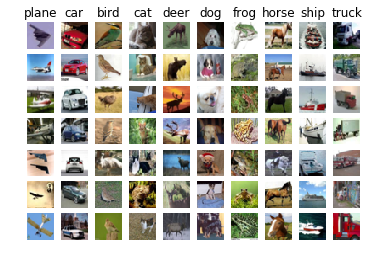

In [19]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)

        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()


## Part (a)
Run the SVM, using the RBF kernel. Note that, to classify points with more than two classes, we employ the "one versus rest" classification technique discussed in lecture. So we are really training $k - 1$ binary classifiers (where we have $k$ classes) and combining them together into a single $k$-fold classifier.

In [20]:
# Preprocessing: reshape the image data into rows
X_train_ = np.reshape(X_train, (X_train.shape[0], -1))
X_val_ = np.reshape(X_val, (X_val.shape[0], -1))

# normalize data
X_train_ = normalize(X_train_)
X_val_ = normalize(X_val_)

In [ ]:
acc_train_svm = []
acc_test_svm = []
c_svm = [0.1, 0.5, 1, 2, 10]

for c in tqdm(c_svm):
    acc, acc2 = svm_alg(c, 'auto', X_train_, y_train, X_val_, y_val, kernel="rbf")
    acc_train_svm.append(acc)
    acc_test_svm.append(acc2)

    
plt.plot(c_svm, acc_train_svm,'r.-', label="Training")
plt.plot(c_svm, acc_test_svm,'go-', label="Test")
plt.xlabel('c')
plt.ylabel('Accuracy')
plt.title("Plot of accuracy vs c for training and test data")
plt.legend()
plt.grid()

  0%|          | 0/5 [00:00<?, ?it/s]

c = 0.1


## Part (b)
Run SVM with multi-scale RBF kernel.

In [ ]:
# multiscale
X_train_ = multiscale(X_train)
X_val_ = multiscale(X_val)

# normalize data
X_train_ = normalize(X_train_)
X_val_ = normalize(X_val_)

In [ ]:
acc_train_svm_mul = []
acc_test_svm_mul = []
c_svm = [0.1, 0.5, 1, 2, 10]

for c in tqdm(c_svm):
    acc, acc2 = svm_alg(c, 'auto', X_train_, y_train, X_val_, y_val, kernel="rbf")
    acc_train_svm_mul.append(acc)
    acc_test_svm_mul.append(acc2)

plt.plot(c_svm, acc_train_svm,'r.-', label="Train")
plt.plot(c_svm, acc_test_svm,'g^-', label="Val")
plt.plot(c_svm, acc_train_svm_mul,'b^--', label="Train_ms")
plt.plot(c_svm, acc_test_svm_mul,'kx:', label="Val_ms")
plt.xlabel('c')
plt.ylabel('Accuracy')
plt.title("Plot of accuracy vs c for training and test data")
plt.legend()
plt.grid()